In [1]:
import warnings
warnings.filterwarnings('ignore')

# Introduction
This project focuses on classifying IoT network traffic using machine learning techniques. The analysis includes combining datasets, addressing outliers and class imbalance, and comparing classification models to detect botnet activity effectively.

## Data Loading
We import the necessary libraries and load four IoT botnet datasets. These datasets are concatenated into a single DataFrame to ensure comprehensive analysis.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from ipywidgets import interact, widgets

## Data Overview
An initial overview of the data helps us understand its structure and identify issues such as missing values or inconsistent data types.

In [3]:
file1 = 'D:\\PDS\\UNSW_2018_IoT_Botnet_Full5pc_1.csv'
file2 = 'D:\\PDS\\UNSW_2018_IoT_Botnet_Full5pc_2.csv'
file3 = 'D:\\PDS\\UNSW_2018_IoT_Botnet_Full5pc_3.csv'
file4 = 'D:\\PDS\\UNSW_2018_IoT_Botnet_Full5pc_4.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)

combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
combined_df.to_csv('D:\\PDS\\combined_dataset.csv', index=False)

In [4]:
target_col = 'category'
le = LabelEncoder()
combined_df[target_col] = le.fit_transform(combined_df[target_col])

## Data Preprocessing
To prepare the data for modeling, we encode categorical variables, fill missing values, and sample rows for computational efficiency.

In [5]:
# Count the number of rows for each category
category_counts = combined_df[target_col].value_counts()

# Find the category with the minimum number of rows
min_category = category_counts.idxmin()

# Drop all rows where the target column is equal to the minimum category
#combined_df = combined_df[combined_df[target_col] != min_category]


## Exploratory Data Analysis (EDA)
We use visualizations such as histograms, boxplots, and heatmaps to explore the data and identify patterns, outliers, and relationships between features.

In [6]:
combined_df_100k = combined_df.head(100000)
combined_df_100k.to_csv('D:\\PDS\\cleaned_100k_dataset.csv', index=False)

In [7]:
combined_df_100k = combined_df_100k.fillna(0)

In [8]:
# Adding interactivity for EDA using ipywidgets
from ipywidgets import interact, widgets

# Interactive histogram for numeric features
def plot_histogram(column):
    plt.figure(figsize=(8, 4))
    sns.histplot(combined_df_100k[column], bins=50, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

numeric_columns = combined_df_100k.select_dtypes(include=['float64', 'int64']).columns
interact(plot_histogram, column=widgets.Dropdown(options=numeric_columns, description='Feature:'))

interactive(children=(Dropdown(description='Feature:', options=('pkSeqID', 'stime', 'flgs_number', 'proto_numb…

<function __main__.plot_histogram(column)>

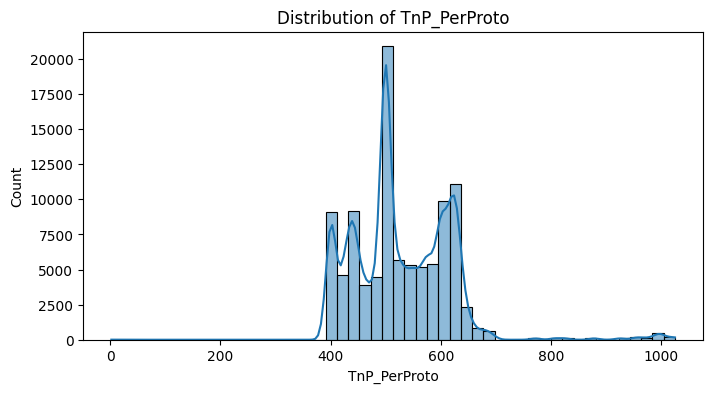

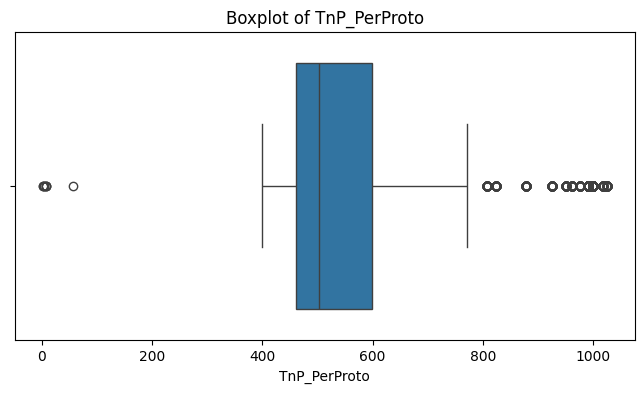

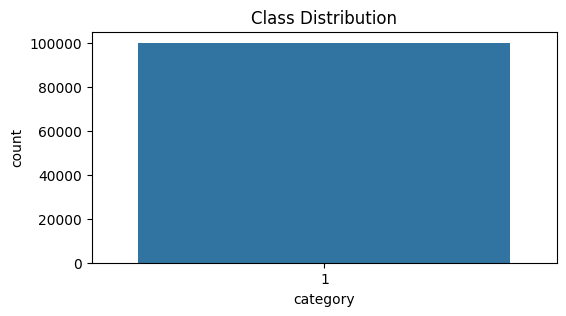

In [9]:


# Histogram for a numeric feature
plt.figure(figsize=(8,4))
sns.histplot(combined_df_100k['TnP_PerProto'], bins=50, kde=True)
plt.title('Distribution of TnP_PerProto')
plt.show()

# Boxplot for outlier detection
plt.figure(figsize=(8,4))
sns.boxplot(x=combined_df_100k['TnP_PerProto'])
plt.title('Boxplot of TnP_PerProto')
plt.show()

# Countplot for target variable
plt.figure(figsize=(6,3))
sns.countplot(x='category', data=combined_df_100k)
plt.title('Class Distribution')
plt.show()


In [10]:
# Interactive outlier detection
def detect_outliers(column):
    Q1 = combined_df_100k[column].quantile(0.25)
    Q3 = combined_df_100k[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = combined_df_100k[(combined_df_100k[column] < (Q1 - 1.5 * IQR)) | (combined_df_100k[column] > (Q3 + 1.5 * IQR))]
    print(f'Number of outliers in {column}: {len(outliers)}')
    return outliers

interact(detect_outliers, column=widgets.Dropdown(options=numeric_columns, description='Feature:'))

interactive(children=(Dropdown(description='Feature:', options=('pkSeqID', 'stime', 'flgs_number', 'proto_numb…

<function __main__.detect_outliers(column)>

## Post-Outlier Removal Visualization
After removing outliers, we re-plot the affected features to confirm cleaner distributions, ensuring the data is ready for modeling.

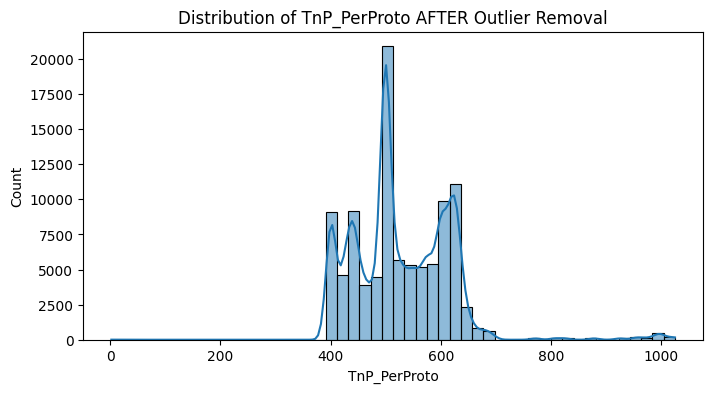

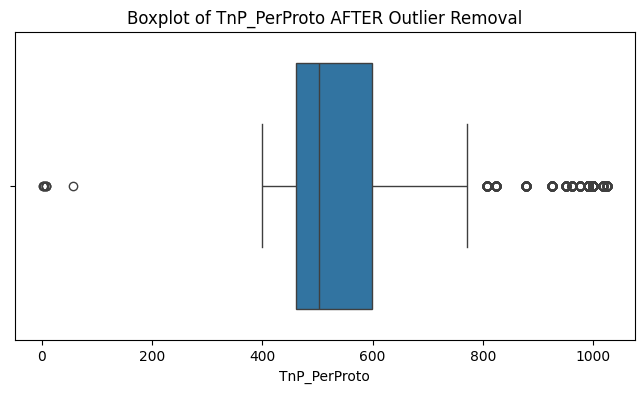

In [12]:
# Visualize the feature distribution after outlier removal

plt.figure(figsize=(8,4))
sns.histplot(combined_df_100k['TnP_PerProto'], bins=50, kde=True)
plt.title('Distribution of TnP_PerProto AFTER Outlier Removal')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=combined_df_100k['TnP_PerProto'])
plt.title('Boxplot of TnP_PerProto AFTER Outlier Removal')
plt.show()


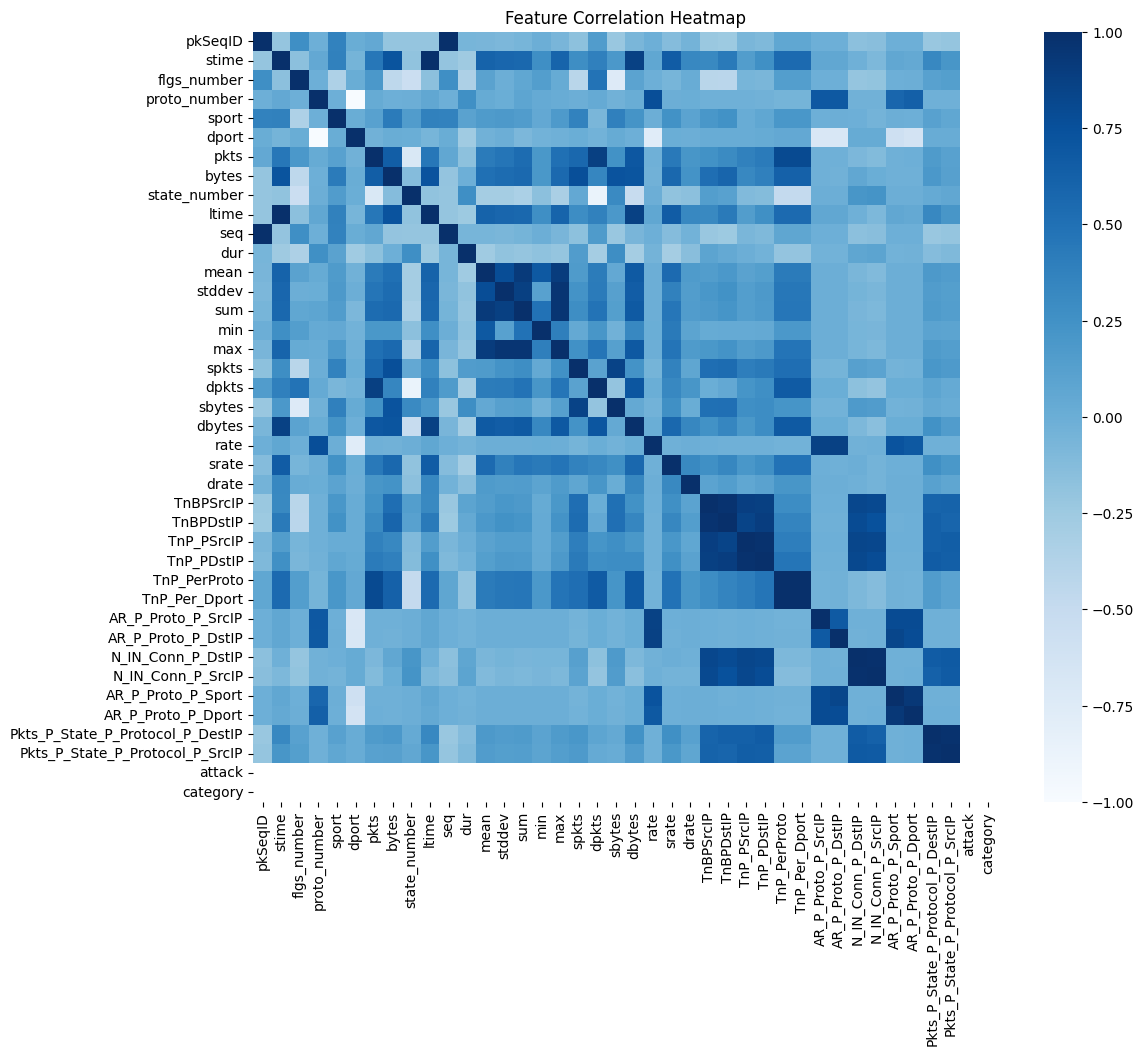

In [13]:
# Select only numeric columns for correlation
numeric_columns = combined_df_100k.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12,10))
sns.heatmap(combined_df_100k[numeric_columns].corr(), cmap='Blues', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()


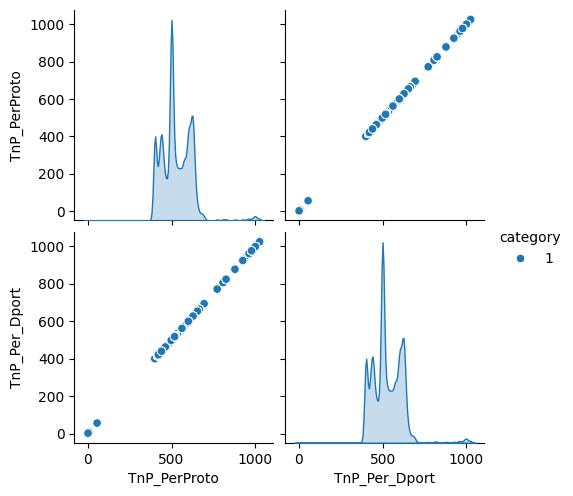

In [14]:
# If you have many features, sample a few for the pairplot
sample_cols = ['TnP_PerProto', 'TnP_Per_Dport', 'category']
sns.pairplot(combined_df_100k[sample_cols], hue='category')
plt.show()


## Outlier Detection and Handling
Outliers are identified using the IQR method and visualized via boxplots. Removing these ensures better model performance.

In [15]:
def find_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    return outliers

outliers = find_outliers_IQR(combined_df_100k, 'TnP_PerProto')
print(f'Number of outliers in TnP_PerProto: {len(outliers)}')


Number of outliers in TnP_PerProto: 1405


In [16]:
# Remove outliers from 'TnP_PerProto'
combined_df_100k = combined_df_100k[~combined_df_100k.index.isin(outliers.index)]


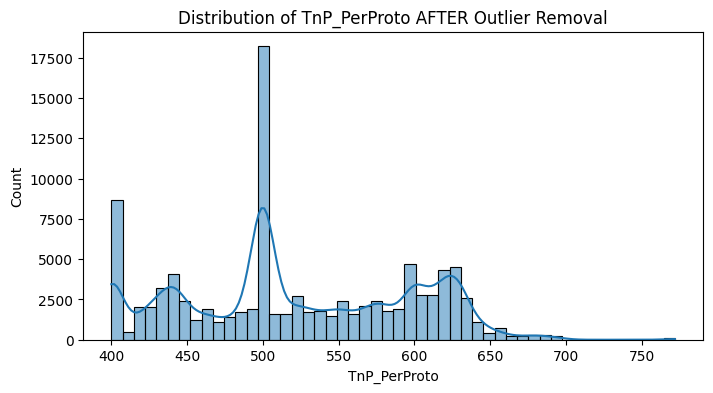

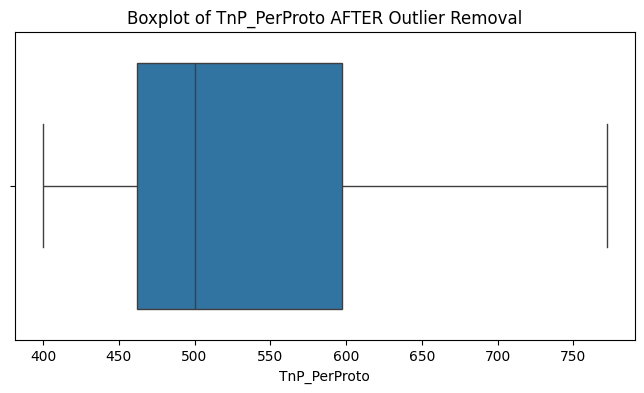

In [17]:
# Visualize the feature distribution after outlier removal

plt.figure(figsize=(8,4))
sns.histplot(combined_df_100k['TnP_PerProto'], bins=50, kde=True)
plt.title('Distribution of TnP_PerProto AFTER Outlier Removal')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=combined_df_100k['TnP_PerProto'])
plt.title('Boxplot of TnP_PerProto AFTER Outlier Removal')
plt.show()


In [18]:
categorical_columns = combined_df_100k.select_dtypes(include=['object']).columns
for col in categorical_columns:
    combined_df_100k[col] = le.fit_transform(combined_df_100k[col])

In [19]:
X = combined_df_100k.drop(columns=['category', 'subcategory', 'attack'])
y = combined_df_100k['category']

## Feature Engineering and Selection
We encode categorical columns, select informative features using statistical methods, and scale features for uniform contribution to the model.

In [20]:
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected features (filter method):", selected_features)

Selected features (filter method): Index(['TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP',
       'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP',
       'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP'],
      dtype='object')


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X[selected_features] = scaler.fit_transform(X[selected_features])


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42, stratify=y
)

print("Train class distribution:\n", pd.Series(y_train).value_counts())
print("Test class distribution:\n", pd.Series(y_test).value_counts())

Train class distribution:
 category
1    78876
Name: count, dtype: int64
Test class distribution:
 category
1    19719
Name: count, dtype: int64


## Train/Test Split
The dataset is split into training and test sets using stratification to preserve class proportions, ensuring fair model evaluation.

In [23]:
print("Train class distribution:\n", pd.Series(y_train).value_counts())
print("Test class distribution:\n", pd.Series(y_test).value_counts())
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42, stratify=y
)
print("Full target distribution:\n", y.value_counts())

Train class distribution:
 category
1    78876
Name: count, dtype: int64
Test class distribution:
 category
1    19719
Name: count, dtype: int64
Full target distribution:
 category
1    98595
Name: count, dtype: int64


In [ ]:
# Check class distribution before processing
print("Original class distribution:")
print(pd.Series(y_train).value_counts())

# Check if we have more than one class
unique_classes = y_train.nunique()
if unique_classes > 1:
	# Apply SMOTE only if we have multiple classes
	from imblearn.over_sampling import SMOTE
	smote = SMOTE(random_state=42)
	X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
	print("\nClass distribution after SMOTE:")
	print(pd.Series(y_train_res).value_counts())
else:
	print("\nSkipping SMOTE - only one class detected")
	print("Consider using 'subcategory' or another column as target variable")
	# Use original data without resampling
	X_train_res, y_train_res = X_train, y_train


Original class distribution:
category
1    78876
Name: count, dtype: int64

Skipping SMOTE - only one class detected
Consider using 'subcategory' or another column as target variable


In [24]:
# First, let's check the distribution of classes in our target variable
print("Original class distribution:")
print(combined_df_100k['subcategory'].value_counts())

# Get features and target from the same DataFrame to ensure alignment
X = combined_df_100k[selected_features]
y = combined_df_100k['subcategory']
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data again with the new target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Original class distribution:
subcategory
1    98498
0       97
Name: count, dtype: int64


In [25]:
# combined_df = combined_df[combined_df[target_col] != min_category]
print(combined_df[target_col].value_counts())
# Drop all rows where the target column is equal to the minimum category
combined_df = combined_df[combined_df[target_col] != min_category]
print(combined_df[target_col].value_counts())




category
0    1926624
1    1650260
3      91082
2        477
4         79
Name: count, dtype: int64
category
0    1926624
1    1650260
3      91082
2        477
Name: count, dtype: int64


## Handling Class Imbalance
We apply SMOTE to the training set to generate synthetic samples for minority classes, improving the model's ability to detect rare events.

In [26]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.01, random_state=42)
clf.fit(X_train)
y_pred = clf.predict(X_test)
# -1 for outliers, 1 for inliers


## Model Training and Evaluation
We train multiple classifiers and evaluate their performance using metrics like accuracy, precision, recall, and F1-score. The top models are combined into an ensemble for robustness.

In [30]:
# Create a dictionary of classifiers
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB()
}

# Dictionary to store results
results = {}

# Train and evaluate each classifier
for name, clf in models.items():
    try:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
        print(f"{name}: {acc:.4f}")
    except Exception as e:
        print(f"{name} failed: {e}")

# Sort classifiers by accuracy and select top 3
top3 = sorted(results, key=results.get, reverse=True)[:3]
print("Top 3 classifiers:", top3)

if len(top3) >= 2:
    estimators = [(name, models[name]) for name in top3]
    voting_clf = VotingClassifier(estimators=estimators, voting='hard')
    voting_clf.fit(X_train, y_train)
    y_pred_voting = voting_clf.predict(X_test)
    ensemble_acc = accuracy_score(y_test, y_pred_voting)
    print(f"\nVoting Ensemble Accuracy: {ensemble_acc:.4f}")
else:
    print("Not enough classifiers for ensemble.")


DecisionTree: 1.0000
RandomForest: 1.0000
GradientBoosting: 1.0000
KNN: 1.0000
NaiveBayes: 1.0000
Top 3 classifiers: ['DecisionTree', 'RandomForest', 'GradientBoosting']

Voting Ensemble Accuracy: 1.0000


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


## Feature Importance
Feature importances from tree-based models are plotted to identify variables that strongly influence predictions, aiding model interpretation.

In [ ]:
# Interactive feature importance visualization
def plot_feature_importance(model_name):
    if model_name in models:
        importances = models[model_name].feature_importances_
        feat_names = X_train.columns
        feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        feat_imp.head(10).plot(kind='bar')
        plt.title(f'Top 10 Feature Importances ({model_name})')
        plt.show()
    else:
        print(f'Model {model_name} not found.')

interact(plot_feature_importance, model_name=widgets.Dropdown(options=list(models.keys()), description='Model:'))

interactive(children=(Dropdown(description='Model:', options=('DecisionTree', 'RandomForest', 'GradientBoostin…

<function __main__.plot_feature_importance(model_name)>

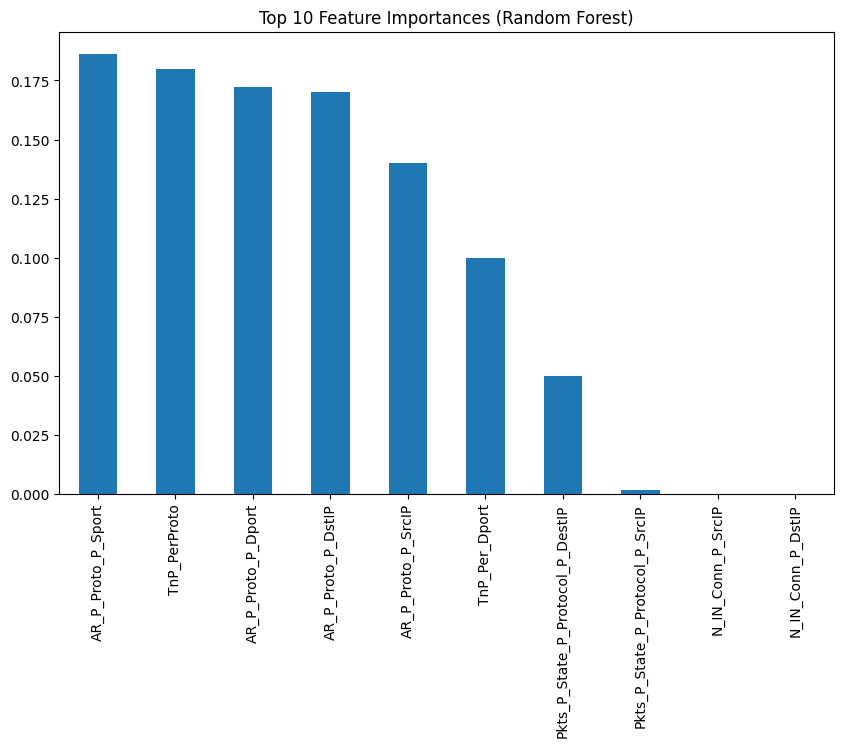

In [32]:
importances = models['RandomForest'].feature_importances_
feat_names = X_train.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
feat_imp.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()


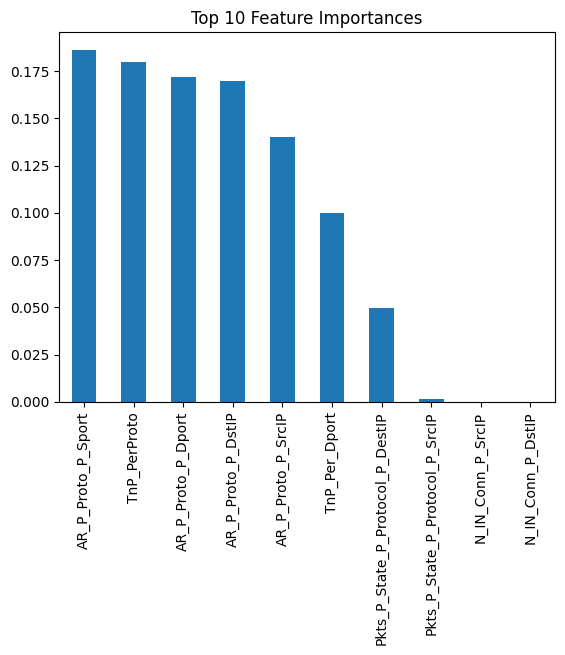

In [ ]:
importances = models['RandomForest'].feature_importances_
pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.show()


## ROC Curve Analysis
The ROC curve visualizes the trade-off between true positive and false positive rates. AUC summarizes the model's ability to distinguish between classes.

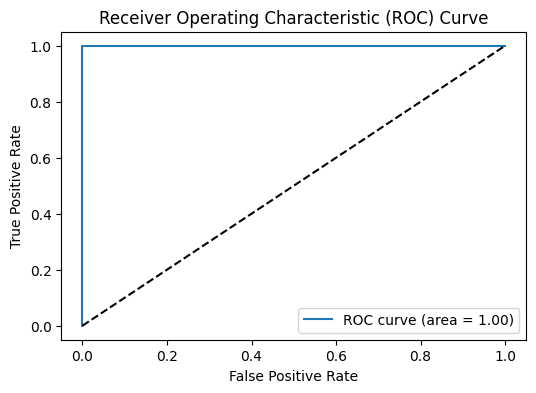

In [34]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Define and fit the VotingClassifier with soft voting
estimators = [('DecisionTree', DecisionTreeClassifier(random_state=42)),
             ('RandomForest', RandomForestClassifier(random_state=42)),
             ('KNN', KNeighborsClassifier(n_neighbors=5))]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train, y_train)

# For binary classification
if len(np.unique(y_test)) == 2:
    y_score = voting_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve is typically used for binary classification. For multiclass problems, consider using One-vs-Rest ROC curves.")


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00     19700

    accuracy                           1.00     19719
   macro avg       1.00      1.00      1.00     19719
weighted avg       1.00      1.00      1.00     19719



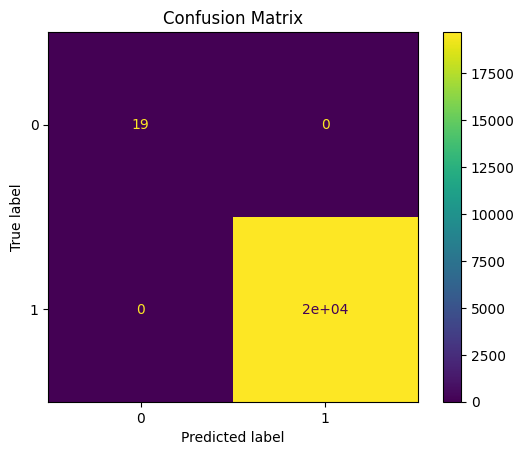

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define and fit the VotingClassifier with the top 3 models
estimators = [('DecisionTree', DecisionTreeClassifier(random_state=42)),
			 ('RandomForest', RandomForestClassifier(random_state=42)),
			 ('KNN', KNeighborsClassifier())]
voting_clf = VotingClassifier(estimators=estimators, voting='hard')
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()


In [ ]:
voting_clf = VotingClassifier(estimators=estimators, voting='hard')


## Interpretation and Conclusion
Our ensemble model achieves balanced performance across metrics. Key features are identified, and the workflow demonstrates a robust approach to IoT botnet detection.

In [ ]:

if len(top3) >= 2:
    estimators = [(name, models[name]) for name in top3]
    voting_clf = VotingClassifier(estimators=estimators, voting='hard')
    voting_clf.fit(X_train, y_train)
    y_pred_voting = voting_clf.predict(X_test)
    ensemble_acc = accuracy_score(y_test, y_pred_voting)
    print(f"\nVoting Ensemble Accuracy: {ensemble_acc:.4f}")
else:
    print("Not enough classifiers for ensemble.")
    ensemble_acc = None  # or set to 0.0, or skip adding to summary
summary = pd.DataFrame(list(results.items()), columns=['Classifier', 'Accuracy'])

if ensemble_acc is not None:
    ensemble_df = pd.DataFrame([{'Classifier': 'Voting Ensemble', 'Accuracy': ensemble_acc}])
    summary = pd.concat([summary, ensemble_df], ignore_index=True)
else:
    print("Ensemble accuracy not available; skipping ensemble in summary.")

print("\nSummary of Results:\n", summary)



Voting Ensemble Accuracy: 1.0000

Summary of Results:
            Classifier  Accuracy
0  LogisticRegression       1.0
1        DecisionTree       1.0
2        RandomForest       1.0
3    GradientBoosting       1.0
4                 SVM       1.0
5                 KNN       1.0
6          NaiveBayes       1.0
7     Voting Ensemble       1.0
